In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from dgpylib import dg_athena
from dgpylib import dg_s3 
import os
import re
from dateutil.relativedelta import relativedelta

import sys
sys.path.insert(0, '../EDA')
import basicstatsandplotter as bstatsplot

import sys
sys.path.insert(0, '../Modelling')
import helper_function2 as hf

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

import parameters

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# query_result = conn.read(query)
# query_result

In [4]:
conn1 = dg_s3.Connect('dgdatadump/DS&CA/Pricing/02 Projects/2022/Tel_Reg_2.0/Cancellation Model')
raw_df = conn1.read('TelReg_Canx_dedup.csv') #TelReg_Canx_dedup

raw_df.head()

,offerreferencenumber,CurrentDate,sale,offertotalprice,contractstatuscode,personaddresspostcode,planaccdate,movementdate,TotalPrice,PeriodOfCover,PricingVersionDescription,PurchaseDate,PurchasePrice,Fee,PlanLiveCount,PlansActivePast1yrCount,PlansActivePast5yrCount,PlansAcceptedPast1YearCount,PlansAcceptedPast5YearCount,PlansCancelledPast1YearCount,PlansCancelledPast5YearCount,ClaimPast1YearCount,ClaimPast3YearCount,ClaimPast5YearCount,ClaimAmount1YearTotal,ClaimAmount3YearTotal,ClaimAmount5YearTotal,GoodsColour,ClientGroupDesc,SchemeTypeName,ClientAccountDesc,RouteToMarketName,ManufacturerGuaranteeLabourMonths,ManufacturerGuaranteePartsMonths,ApplianceCode,ClientGroupCode,ClientCode,ManufacturerBrandCode,Postcode_Sector,price_diff,price_band,HasPrevRTPPrice,AppAge,relFee,relFeeInc,PaymentType,startmonthyear,contractmonthyear,startmonth,contractmonth,contract_age,cancelflag,HPI_AveragePrice,HPI_SalesVolume,ONS_avg_age,ONS_avg_distance_travelled_to_work(km),ONS_%people_working_FT,ONS_%people_working_49+,ONS_%people_working_sum,ONS_avg_household_size,ONS_n_households,ONS_avg_dependent_children_per_family,ONS_n_families,ONS_n_families/n_households,ONS_avg_bedrooms,ONS_avg_rooms,ONS_bedrooms per rooms,ONS_population,ONS_population_density,ONS_occupation_rate,ONS_n_families_per_population
0,004-002-122-629,2022-05-11,1,23.40,N,IP257LB,2022-05-11,2022-05-11,23.40,12.0,TELREGOPTTARGET27%,2022-05-09,309.99,33.24,0,0,1,0,0,0,1,0,0,0,0.0,0.0,0.00,W,ELECTROLUXGROUP,TELEPHONEREGISTRATION,AEG,REG,24.0,24.0,CH,168.0,4.0,AEG,IP257,-0.296029,"[0.699,0.8]",N,2.0,0.107229,-0.000955,DD,2022-05,2022-05,May,May,3.252634,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,170-008-962-332,2021-07-16,1,39.48,R,M156HD,2021-07-16,2022-07-11,39.48,12.0,ASISFEE,2021-07-16,499.00,39.48,1,3,4,0,3,2,3,0,0,1,0.0,0.0,354.91,W,WHIRLPOOL,TELEPHONEREGISTRATION,HOTPOINT,REG,12.0,120.0,CK,138.0,170.0,HOTP,M156,0.000000,"[0.99,1.0]",Y,0.0,0.079118,0.000000,DD,2021-07,2022-07,July,July,13.076244,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,170-008-591-165,2021-06-05,1,54.24,C,NP167AT,2021-06-05,2021-08-09,54.24,12.0,ASISFEE,2020-06-05,300.00,54.24,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.00,W,INDESITCOMPANY,TELEPHONEREGISTRATION,INDESIT,REG,12.0,120.0,AW,138.0,170.0,INDE,NP167,0.000000,"[0.99,1.0]",N,365.0,0.180800,0.000000,DD,2021-06,2021-08,June,August,2.135567,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,351-017-156-535,2022-07-14,1,58.44,N,W114HF,2022-07-14,2022-07-14,58.44,12.0,ASISFEE,2021-07-14,249.17,58.44,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.00,W,HOOVERCANDYGROUP,TELEPHONEREGISTRATION,HOOVER,REG,12.0,120.0,AW,296.0,351.0,HOOV,W114,0.000000,"[0.99,1.0]",N,365.0,0.234539,0.000000,DD,2022-07,2022-07,July,July,1.149921,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,301-000-086-262,2021-07-05,1,36.96,R,RG49EZ,2021-07-05,2022-07-01,36.96,12.0,ASISFEE,2021-06-28,300.00,36.96,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.00,W,WHIRLPOOL,TELEPHONEREGISTRATION,HOTPOINT,REG,24.0,12.0,DW,138.0,170.0,HOTP,RG49,0.000000,"[0.99,1.0]",N,7.0,0.123200,0.000000,DD,2021-07,2022-07,July,July,13.437648,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
raw_df.shape

(641180, 71)

In [7]:
raw_df.PricingVersionDescription.unique()

array(['TELREGOPTTARGET27%', 'ASISFEE', 'TELREGOPTTARGET26.0%',
       'FEE+-30%', 'TELREGHYBRID(EUNICE)OPTTARGET23'], dtype=object)

In [8]:
# ????Filter out offers cancelled within 30 days?????

# filt_df = raw_df.loc[(raw_df['daystocancel']>30)|(raw_df['daystocancel'].isna())]

In [9]:
print(raw_df['movementdate'].min(), raw_df['movementdate'].max())
print(raw_df['planaccdate'].min(), raw_df['planaccdate'].max())

2021-01-02 2022-08-18
2021-01-01 2022-08-17


## Date Formatting

In [10]:
date_cols = raw_df.columns[raw_df.columns.str.lower().str.contains('date')]
date_cols

# date formatting 

def date_fix(df, cols):
    df[cols] = df[cols].apply(pd.to_datetime)

date_fix(raw_df, date_cols)

## Preliminary Date Filter

In [11]:
# Cohort Filter - select only jun & jul 21 start dates

filt_df12 = raw_df[(raw_df['planaccdate']>='2021-06-01')&(raw_df['planaccdate']<'2021-08-01')] # 2 + 12 = 14 (aug 22)
filt_df9 = raw_df[(raw_df['planaccdate']>='2021-06-01')&(raw_df['planaccdate']<'2021-11-01')] # 5 + 9 = 14 (aug 22)
filt_df6 = raw_df[(raw_df['planaccdate']>='2021-06-01')&(raw_df['planaccdate']<'2022-02-01')] # 8 + 6 = 14 (aug 22)
filt_df3 = raw_df[(raw_df['planaccdate']>='2021-06-01')&(raw_df['planaccdate']<'2022-05-01')] # 11 + 3 = 14 (aug 22)

## Cancellation by Months of Tenure: 12 months
With 12-month observation period

In [12]:
final_planaccdate = pd.Timestamp('2021-07-31 00:00:00')
final_movementdate = final_planaccdate + relativedelta(months=12)
final_movementdate

Timestamp('2022-07-31 00:00:00')

In [13]:
# re-calculate contract_age
filt_df12['contract_age']=np.where(filt_df12['contractstatuscode']=='C',(filt_df12['movementdate']-filt_df12['planaccdate'])/np.timedelta64(1, 'M'), (final_movementdate-filt_df12['planaccdate'])/np.timedelta64(1, 'M'))

filt_df12[filt_df12['contractstatuscode']=='C']['contract_age'].describe()

/tmp/ipykernel_15925/1121359504.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df12['contract_age']=np.where(filt_df12['contractstatuscode']=='C',(filt_df12['movementdate']-filt_df12['planaccdate'])/np.timedelta64(1, 'M'), (final_movementdate-filt_df12['planaccdate'])/np.timedelta64(1, 'M'))


count    16562.000000
mean         4.596934
std          4.168890
min          0.000000
25%          0.624243
50%          3.351198
75%          8.016592
max         14.357584
Name: contract_age, dtype: float64

In [14]:
filt_df12.shape

(66895, 71)

In [15]:
# re-label plans that cancelled beyond 12 months observation period as not cancelled ('N')
filt_df12['contractstatuscode'] = np.where((filt_df12['contractstatuscode']=='C')&(filt_df12['contract_age']>=12), 'N', filt_df12['contractstatuscode'])
filt_df12[filt_df12['contractstatuscode']=='C']['contract_age'].max()

/tmp/ipykernel_15925/2024753662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df12['contractstatuscode'] = np.where((filt_df12['contractstatuscode']=='C')&(filt_df12['contract_age']>=12), 'N', filt_df12['contractstatuscode'])


11.992032690609664

In [16]:
# re-label cancelflag
filt_df12['cancelflag']=np.where(filt_df12['contractstatuscode']=='C', 1, 0)

/tmp/ipykernel_15925/881599839.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df12['cancelflag']=np.where(filt_df12['contractstatuscode']=='C', 1, 0)


array([[<AxesSubplot:title={'center':'contract_age'}>]], dtype=object)

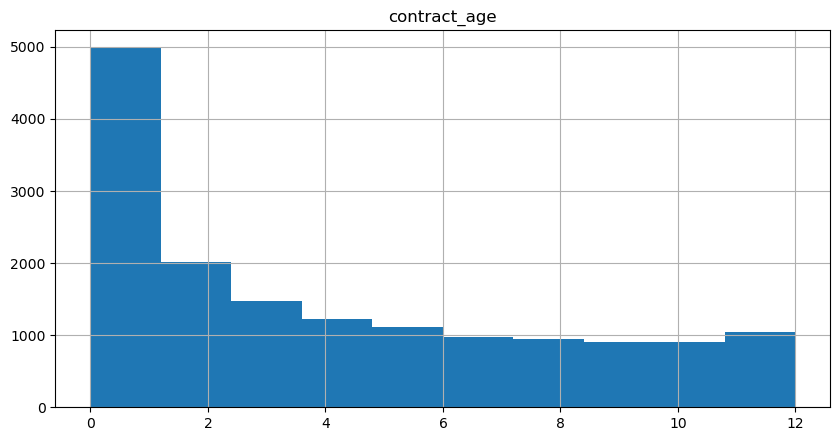

In [17]:
# plot distribution of contract tenure for cancelled contracts
df_canx_tenure = pd.DataFrame(filt_df12[filt_df12['contractstatuscode']=='C']['contract_age'])
df_canx_tenure.hist()

In [18]:
df_month = pd.DataFrame(filt_df12.groupby(['startmonthyear']).agg({'cancelflag': lambda x: x.sum(),'offerreferencenumber': lambda x: x.count()})).reset_index()

df_month.columns = ['startmonthyear','cancel_count', 'offers']
# df_month['cum_cancels'] = df_month['cancel_count'].cumsum()
# df_month['cum_offers'] = df_month['offers'].cumsum()
# df_month['cum_cancel_rate'] = df_month['cum_cancels']/df_month['cum_offers']
df_month['cancel_rate'] = df_month['cancel_count']/(df_month['offers'])

  startmonthyear  cancel_count  offers  cancel_rate
0        2021-06          7732   33198     0.232906
1        2021-07          7874   33697     0.233671


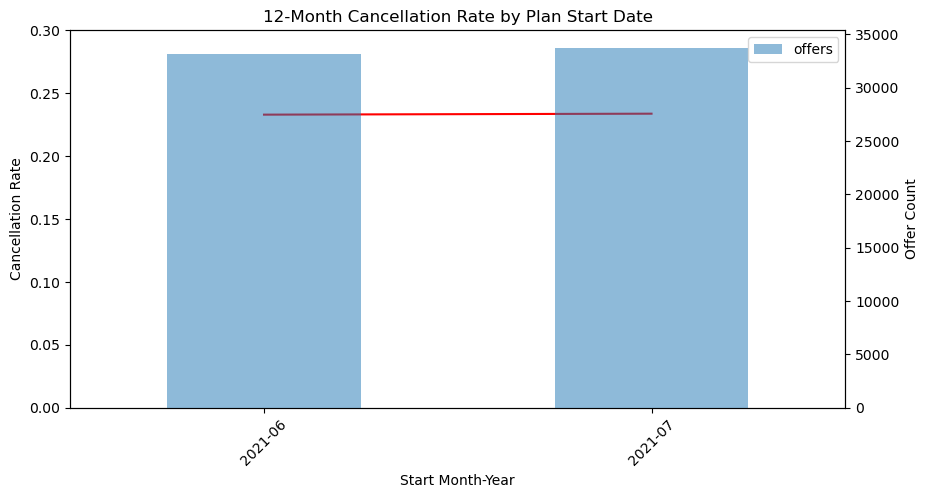

In [19]:
# Plot cancellation rate

y1 = df_month['cancel_rate']
y2 = df_month['offers']

x = df_month['startmonthyear']


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(x, y1, color = 'red', label = 'Cancellation Rate')
y2.plot.bar(alpha=0.5)


# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel("Start Month-Year")
ax1.set_ylabel("Cancellation Rate")
ax2.set_ylabel("Offer Count")
ax1.set_xticklabels(x, rotation=45)

ax1.set_xticklabels(x)
ax1.set_ylim([0, .3])

plt.legend()
plt.title('12-Month Cancellation Rate by Plan Start Date')

print(df_month)

plt.show()

In [20]:
parameters.leaky_feats + parameters.redundant_feats + list(date_cols)

['movementdate',
 'contractmonthyear',
 'offereventmonth',
 'contractmonth',
 'contractstatuscode',
 'planaccdate',
 'contract_age',
 'sale',
 'startmonthyear',
 'offermonthyear',
 'offerreferencenumber',
 'startmonth',
 'year',
 'CurrentDate',
 'PurchaseDate',
 'SchemeTypeName',
 'RouteToMarketName',
 'CurrentDate',
 'planaccdate',
 'movementdate',
 'PurchaseDate']

In [ ]:
filt_df12[['Postcode_Sector', 'personaddresspostcode', 'CurrentDate']].head()

In [30]:
# for earnix
conn1.write(filt_df12, 'Earnix_Data/TelReg_Canx_12mo.csv')

File saved as :Earnix_Data/TelReg_Canx_12mo.csv


In [ ]:
# for modelling 
# re-add PaymentType, PeriodOfCover, OfferPostcodeSector, PurchaseDate, PurchasePrice
# drop leaky & redundant features
filt_df12_clean = hf.drop_columns(filt_df12, parameters.leaky_feats + parameters.redundant_feats + list(date_cols))
# save dataset for modelling
conn1.write(filt_df12_clean, 'Modelling_Data/TelReg_Canx_filt_12mo.csv')

## Cancellation by Months of Tenure: 9 months
With 9-month observation period

In [22]:
# re-calculate contract age

filt_df9['contract_age']=np.where(filt_df9['contractstatuscode']=='C', (filt_df9['movementdate']-filt_df9['planaccdate'])/np.timedelta64(1, 'M'), (final_movementdate-filt_df9['planaccdate'])/np.timedelta64(1, 'M'))

filt_df9[filt_df9['contractstatuscode']=='C']['contract_age'].describe()

/tmp/ipykernel_15925/2204384479.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df9['contract_age']=np.where(filt_df9['contractstatuscode']=='C', (filt_df9['movementdate']-filt_df9['planaccdate'])/np.timedelta64(1, 'M'), (final_movementdate-filt_df9['planaccdate'])/np.timedelta64(1, 'M'))


count    38981.000000
mean         4.009928
std          3.695888
min          0.000000
25%          0.558533
50%          2.989794
75%          6.800961
max         14.357584
Name: contract_age, dtype: float64

In [23]:
# re-label plans that cancelled after 9 months
filt_df9['contractstatuscode'] = np.where((filt_df9['contractstatuscode']=='C')&(filt_df9['contract_age']>=9), 'N', filt_df9['contractstatuscode'])
filt_df9[filt_df9['contractstatuscode']=='C']['contract_age'].max()

/tmp/ipykernel_15925/2368689416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df9['contractstatuscode'] = np.where((filt_df9['contractstatuscode']=='C')&(filt_df9['contract_age']>=12), 'N', filt_df9['contractstatuscode'])


11.992032690609664

In [24]:
# re-label cancelflag
filt_df9['cancelflag']=np.where(filt_df9['contractstatuscode']=='C', 1, 0)

/tmp/ipykernel_15925/657243915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df9['cancelflag']=np.where(filt_df9['contractstatuscode']=='C', 1, 0)


array([[<AxesSubplot:title={'center':'contract_age'}>]], dtype=object)

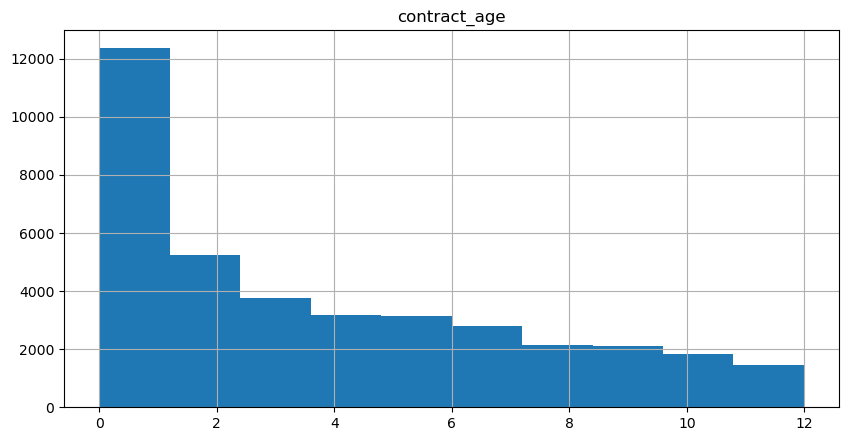

In [25]:
# plot distribution of contract tenure for cancelled contracts
df_canx_tenure = pd.DataFrame(filt_df9[filt_df9['contractstatuscode']=='C']['contract_age'])
df_canx_tenure.hist()

In [26]:
df_month = pd.DataFrame(filt_df9.groupby(['startmonthyear']).agg({'cancelflag': lambda x: x.sum(),'offerreferencenumber': lambda x: x.count()})).reset_index()

df_month.columns = ['startmonthyear','cancel_count', 'offers']
# df_month['cum_cancels'] = df_month['cancel_count'].cumsum()
# df_month['cum_offers'] = df_month['offers'].cumsum()
# df_month['cum_cancel_rate'] = df_month['cum_cancels']/df_month['cum_offers']
df_month['cancel_rate'] = df_month['cancel_count']/(df_month['offers'])

  startmonthyear  cancel_count  offers  cancel_rate
0        2021-06          7732   33198     0.232906
1        2021-07          7874   33697     0.233671
2        2021-08          7330   31968     0.229292
3        2021-09          7454   33530     0.222308
4        2021-10          7635   35426     0.215520


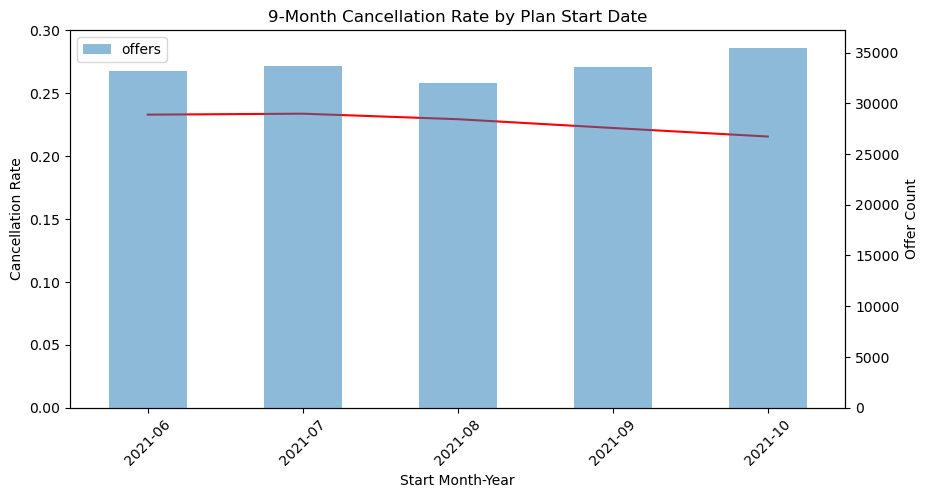

In [27]:
# Plot cancellation rate

y1 = df_month['cancel_rate']
y2 = df_month['offers']

x = df_month['startmonthyear']


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(x, y1, color = 'red', label = 'Cancellation Rate')
y2.plot.bar(alpha=0.5)


# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel("Start Month-Year")
ax1.set_ylabel("Cancellation Rate")
ax2.set_ylabel("Offer Count")
ax1.set_xticklabels(x, rotation=45)

ax1.set_xticklabels(x)
ax1.set_ylim([0, .3])

plt.legend()
plt.title('9-Month Cancellation Rate by Plan Start Date')
print(df_month)
plt.show()

In [29]:
# for earnix
conn1.write(filt_df9, 'Earnix_Data/TelReg_Canx_9mo.csv')

File saved as :Earnix_Data/TelReg_Canx_9mo.csv


In [ ]:
# drop leaky & redundant features
filt_df9_clean = hf.drop_columns(filt_df9, parameters.leaky_feats + parameters.redundant_feats + list(date_cols))

# save dataset for modelling
conn1.write(filt_df9_clean, 'TelReg_Canx_filt_9mo.csv')

## Cancellation by Months of Tenure: 6 months
With 6-month observation period

In [31]:
# re-calculate contract age
filt_df6['contract_age']=np.where(filt_df6['contractstatuscode']=='C', (filt_df6['movementdate']-filt_df6['planaccdate'])/np.timedelta64(1, 'M'), (final_movementdate-filt_df6['planaccdate'])/np.timedelta64(1, 'M'))

filt_df6[filt_df6['contractstatuscode']=='C']['contract_age'].describe()

/tmp/ipykernel_15925/3109735923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df6['contract_age']=np.where(filt_df6['contractstatuscode']=='C', (filt_df6['movementdate']-filt_df6['planaccdate'])/np.timedelta64(1, 'M'), (final_movementdate-filt_df6['planaccdate'])/np.timedelta64(1, 'M'))


count    59108.000000
mean         3.510964
std          3.376605
min          0.000000
25%          0.459968
50%          2.529826
75%          5.749605
max         14.357584
Name: contract_age, dtype: float64

In [32]:
# re-label plans that cancelled after 6 months
filt_df6['contractstatuscode'] = np.where((filt_df6['contractstatuscode']=='C')&(filt_df6['contract_age']>=6), 'N', filt_df6['contractstatuscode'])
filt_df6[filt_df6['contractstatuscode']=='C']['contract_age'].max()

/tmp/ipykernel_15925/1652568261.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df6['contractstatuscode'] = np.where((filt_df6['contractstatuscode']=='C')&(filt_df6['contract_age']>=6), 'N', filt_df6['contractstatuscode'])


5.979588903262901

In [33]:
# re-label cancelflag
filt_df6['cancelflag']=np.where(filt_df6['contractstatuscode']=='C', 1, 0)

/tmp/ipykernel_15925/2604272873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df6['cancelflag']=np.where(filt_df6['contractstatuscode']=='C', 1, 0)


array([[<AxesSubplot:title={'center':'contract_age'}>]], dtype=object)

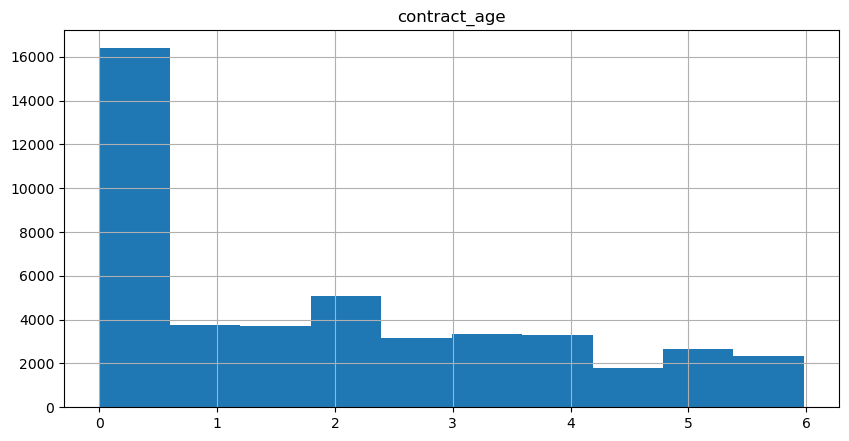

In [34]:
# plot distribution of contract tenure for cancelled contracts
df_canx_tenure = pd.DataFrame(filt_df6[filt_df6['contractstatuscode']=='C']['contract_age'])
df_canx_tenure.hist()

In [35]:
df_month = pd.DataFrame(filt_df6.groupby(['startmonthyear']).agg({'cancelflag': lambda x: x.sum(),'offerreferencenumber': lambda x: x.count()})).reset_index()

df_month.columns = ['startmonthyear','cancel_count', 'offers']
# df_month['cum_cancels'] = df_month['cancel_count'].cumsum()
# df_month['cum_offers'] = df_month['offers'].cumsum()
# df_month['cum_cancel_rate'] = df_month['cum_cancels']/df_month['cum_offers']
df_month['cancel_rate'] = df_month['cancel_count']/(df_month['offers'])

  startmonthyear  cancel_count  offers  cancel_rate
0        2021-06          5354   33198     0.161275
1        2021-07          5470   33697     0.162329
2        2021-08          5158   31968     0.161349
3        2021-09          5596   33530     0.166895
4        2021-10          6104   35426     0.172303
5        2021-11          6444   37262     0.172938
6        2021-12          5961   33462     0.178142
7        2022-01          5531   31995     0.172871


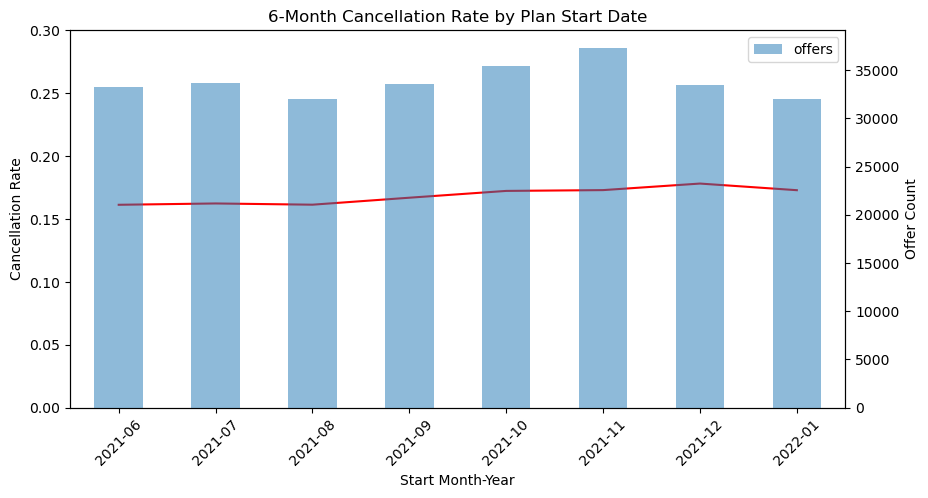

In [36]:
# Plot cancellation rate

y1 = df_month['cancel_rate']
y2 = df_month['offers']

x = df_month['startmonthyear']


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(x, y1, color = 'red', label = 'Cancellation Rate')
y2.plot.bar(alpha=0.5)


# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel("Start Month-Year")
ax1.set_ylabel("Cancellation Rate")
ax2.set_ylabel("Offer Count")
ax1.set_xticklabels(x, rotation=45)

ax1.set_xticklabels(x)
ax1.set_ylim([0, .3])

plt.legend()
plt.title('6-Month Cancellation Rate by Plan Start Date')
print(df_month)
plt.show()

In [37]:
# for earnix
conn1.write(filt_df6, 'Earnix_Data/TelReg_Canx_6mo.csv')

File saved as :Earnix_Data/TelReg_Canx_6mo.csv


In [ ]:
# drop leaky & redundant features for modelling
filt_df6_clean = hf.drop_columns(filt_df6, parameters.leaky_feats + parameters.redundant_feats + list(date_cols))

# save dataset for modelling
conn1.write(filt_df6_clean, 'TelReg_Canx_filt_6mo.csv')


## Cancellation by Months of Tenure: 3 months
With 3-month observation period

In [38]:
# re-calculate contract_age
filt_df3['contract_age']=np.where(filt_df3['contractstatuscode']=='C', (filt_df3['movementdate']-filt_df3['planaccdate'])/np.timedelta64(1, 'M'), (final_movementdate-filt_df3['planaccdate'])/np.timedelta64(1, 'M'))

filt_df3[filt_df3['contractstatuscode']=='C']['contract_age'].describe()

/tmp/ipykernel_15925/3891502580.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df3['contract_age']=np.where(filt_df3['contractstatuscode']=='C', (filt_df3['movementdate']-filt_df3['planaccdate'])/np.timedelta64(1, 'M'), (final_movementdate-filt_df3['planaccdate'])/np.timedelta64(1, 'M'))


count    73149.000000
mean         3.141173
std          3.200499
min          0.000000
25%          0.361404
50%          2.069858
75%          4.928233
max         14.357584
Name: contract_age, dtype: float64

In [39]:
# re-label plans that cancelled after 3 months
filt_df3['contractstatuscode'] = np.where((filt_df3['contractstatuscode']=='C')&(filt_df3['contract_age']>=3), 'N', filt_df3['contractstatuscode'])
filt_df3[filt_df3['contractstatuscode']=='C']['contract_age'].max()

/tmp/ipykernel_15925/4039286583.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df3['contractstatuscode'] = np.where((filt_df3['contractstatuscode']=='C')&(filt_df3['contract_age']>=3), 'N', filt_df3['contractstatuscode'])


2.9897944516314503

In [40]:
# re-label cancelflag
filt_df3['cancelflag']=np.where(filt_df3['contractstatuscode']=='C', 1, 0)

/tmp/ipykernel_15925/2266683748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_df3['cancelflag']=np.where(filt_df3['contractstatuscode']=='C', 1, 0)


array([[<AxesSubplot:title={'center':'contract_age'}>]], dtype=object)

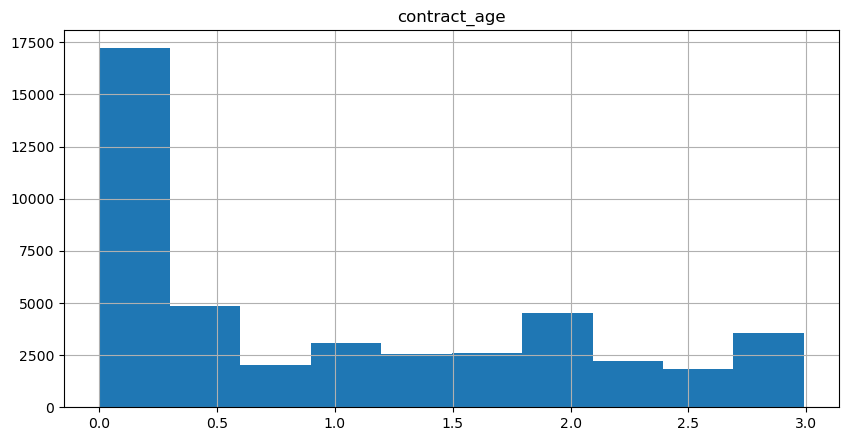

In [41]:
# plot distribution of contract tenure for cancelled contracts
df_canx_tenure = pd.DataFrame(filt_df3[filt_df3['contractstatuscode']=='C']['contract_age'])
df_canx_tenure.hist()

In [42]:
df_month = pd.DataFrame(filt_df3.groupby(['startmonthyear']).agg({'cancelflag': lambda x: x.sum(),'offerreferencenumber': lambda x: x.count()})).reset_index()

df_month.columns = ['startmonthyear','cancel_count', 'offers']
# df_month['cum_cancels'] = df_month['cancel_count'].cumsum()
# df_month['cum_offers'] = df_month['offers'].cumsum()
# df_month['cum_cancel_rate'] = df_month['cum_cancels']/df_month['cum_offers']
df_month['cancel_rate'] = df_month['cancel_count']/(df_month['offers'])

   startmonthyear  cancel_count  offers  cancel_rate
0         2021-06          3908   33198     0.117718
1         2021-07          4060   33697     0.120486
2         2021-08          3873   31968     0.121152
3         2021-09          3941   33530     0.117537
4         2021-10          4202   35426     0.118613
5         2021-11          4513   37262     0.121115
6         2021-12          4393   33462     0.131283
7         2022-01          4165   31995     0.130177
8         2022-02          4003   30082     0.133070
9         2022-03          3561   27691     0.128598
10        2022-04          3869   28747     0.134588


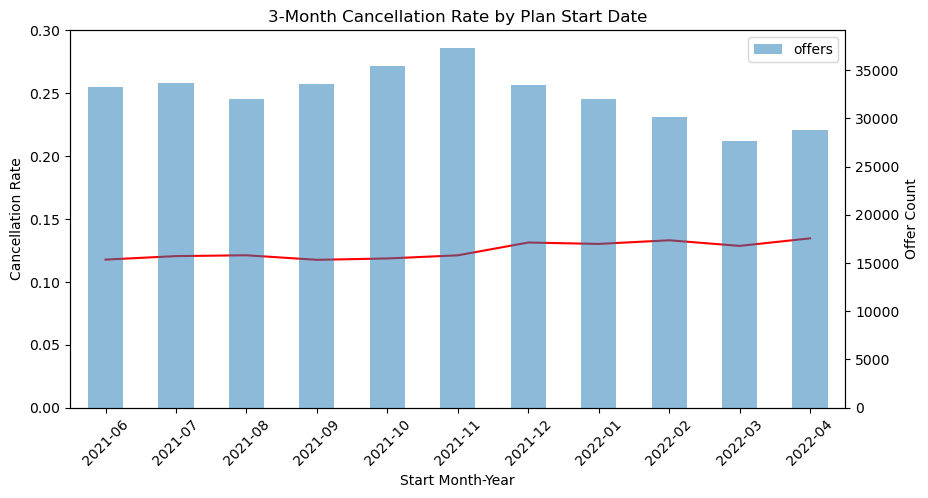

In [43]:
# Plot cancellation rate

y1 = df_month['cancel_rate']
y2 = df_month['offers']

x = df_month['startmonthyear']


fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(x, y1, color = 'red', label = 'Cancellation Rate')
y2.plot.bar(alpha=0.5)


# ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel("Start Month-Year")
ax1.set_ylabel("Cancellation Rate")
ax2.set_ylabel("Offer Count")
ax1.set_xticklabels(x, rotation=45)

ax1.set_xticklabels(x)
ax1.set_ylim([0, .3])

plt.legend()
plt.title('3-Month Cancellation Rate by Plan Start Date')

print(df_month)

plt.show()

In [44]:
# save dataset for earnix
conn1.write(filt_df3, 'Earnix_Data/TelReg_Canx_3mo.csv')

File saved as :Earnix_Data/TelReg_Canx_3mo.csv


In [ ]:
# drop leaky & redundant features for modelling
filt_df3_clean = hf.drop_columns(filt_df3, parameters.leaky_feats + parameters.redundant_feats + list(date_cols))
# save dataset for modelling
conn1.write(filt_df3_clean, 'TelReg_Canx_filt_3mo.csv')